![CAT_DOG](img/cat_dog.jpeg)

# Classifier des images de chiens et de chats avec un MLP

🎯 **Objectif du projet**

Vous devez concevoir, entraîner et évaluer un réseau de neurones de type MLP (Multilayer Perceptron) capable de distinguer des images de chiens et de chats. Ce projet vous permettra de comprendre les bases de la classification supervisée appliquée aux images, en utilisant une architecture dense simple.  

Les images des animaux se trouvent dans `data/pets`.

📝 **Recommandations techniques**
> Taille des images :
- Redimensionnez toutes les images à une taille uniforme, par exemple 64×64 pixels.
- Pour faciliter cet exercice, travaillez avec des images en niveau de gris. 
- Chaque image devra être aplatie (flatten) en un vecteur d’entrée de 4096 valeurs (64×64).
> Architecture du MLP :
- Utilisez 1 à 3 couches cachées avec des activations ReLU. Vous pouvez expérimenter d'autres fonction d'activations.
- La dernière couche doit comporter 1 seul neurone avec une activation sigmoid, car vous êtes sur une tâche de classification binaire.
> Fonction de perte :
- Utilisez impérativement la fonction binary_crossentropy, adaptée à une sortie de type sigmoid.
> Évaluation du modèle :
- Affichez la précision (accuracy) sur l’ensemble d’entraînement et de validation.
- tilisez une matrice de confusion pour analyser les erreurs.
> Prétraitement des données :
- Appliquez une normalisation des pixels (ex. : rescale=1./255) pour faciliter l’apprentissage du modèle.
> Bonnes pratiques :
- Travaillez avec un générateur d’images pour éviter de charger tout en mémoire.
- Séparez bien vos données en train / validation.
> Bonus
- Travaillez avec un générateur d’images pour éviter de charger tout en mémoire : ImageDataGenerator

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.activations import swish
import matplotlib.pyplot as plt
import cv2
from PIL import Image, UnidentifiedImageError
from sklearn.metrics import confusion_matrix
import seaborn as sns
import mlflow
from mlflow.models.signature import infer_signature


np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30)

parameters = {
    "img_size": 48
}

img_size = 48
rgb = False

2025-05-22 17:41:20.782890: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 17:41:20.799666: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 17:41:20.923003: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 17:41:21.042341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747928481.139533   14674 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747928481.16

### Standardisation des images (taille, niveaux de gris, aplatissage)

In [ ]:
# On charge une image depuis un chemin local, l’image est chargé en 1 canal (valeur de pixel de 0 à 255)
img = cv2.imread("data/pets/train/cat/0.jpg", cv2.IMREAD_GRAYSCALE)

# Visualisation de l'image
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

# Inspection des métadonnées de l'image
print(f"Shape (dimensions)    : {img.shape}")
print(f"Type des valeurs      : {img.dtype}")

In [2]:
def get_train_test(base_path: str, img_size:int, rgb:bool):
    X = []  # liste pour stocker les images
    y = []  # liste pour stocker les étiquettes correspondantes

    # On parcourt les sous-dossiers du répertoire (un dossier par chiffre)
    for label in ["cat", "dog"]:

        label_path = os.path.join(base_path, label)

        # On parcourt chaque image du dossier
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)

            try:
                # Redimensionement de l'image
                image = Image.open(file_path)
                new_image = image.convert('RGB').resize((img_size, img_size))

                resized_file_path = os.path.join(label_path + "-resized", file_name)
                new_image.save(resized_file_path)

                # Lecture de l'image en niveaux de gris
                if rgb:
                    img = cv2.imread(resized_file_path, cv2.IMREAD_COLOR_RGB)
                else:
                    img = cv2.imread(resized_file_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue  # image illisible, on passe

                X.append(img)           # on ajoute l'image à la liste
                if label == "cat":
                    y.append(1)    # on ajoute le label (ex: 0, 1, ..., 9)
                else:
                    y.append(0)
                
            except UnidentifiedImageError:
                print(f"❌ Image non reconnue : {file_path}")
                continue
            except Exception as e:
                print(f"❌ Erreur avec {file_path} : {e}")
                continue

    # Conversion des listes en tableaux NumPy
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = get_train_test("data/pets/train", img_size, rgb)
X_test, y_test = get_train_test("data/pets/test", img_size, rgb)

# Les images sont au format (28, 28). On les convertit en float pour normaliser ensuite
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Normalisation : on divise les valeurs de pixels par 255 pour les ramener entre 0 et 1
X_train /= 255.0
X_test /= 255.0

# Flatten : pour un MLP, chaque image img_size*img_size doit devenir un vecteur de img_size² valeurs

if rgb:
    X_train = X_train.reshape(X_train.shape[0], img_size * img_size * 3)
    X_test = X_test.reshape(X_test.shape[0], img_size * img_size * 3)
else:
    X_train = X_train.reshape(X_train.shape[0], img_size * img_size)
    X_test = X_test.reshape(X_test.shape[0], img_size * img_size)


/media/charles-petit/Shared/Formation/Cours/Seng/W6 - Deep Learning/Exercices/DL_challenge_classification_dogs_cats/.venv/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [ ]:
# On charge une image depuis un chemin local, l’image est chargé en 1 canal (valeur de pixel de 0 à 255)
img = cv2.imread("data/pets/train/cat-resized/0.jpg", cv2.IMREAD_COLOR_RGB)

# Visualisation de l'image
plt.imshow(img)
plt.axis("off")
plt.show()

# Inspection des métadonnées de l'image
print(f"Shape (dimensions)    : {img.shape}")
print(f"Type des valeurs      : {img.dtype}")

### PREPARATION AVEC GENERATEUR D'IMAGE

In [81]:
# Suppression des images illisibles
base_path = "data/pets"
for root, _, files in os.walk(base_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)
            img.verify()  # Vérifie si le fichier est une image valide
        except (IOError, SyntaxError) as e:
            print(f"❌ Image illisible : {file_path} ({e})")
            os.remove(file_path)

# Générateur avec normalisation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0)

# Chargement des images depuis le dossier, en niveaux de gris, et redimensionnées
train_gen = datagen.flow_from_directory(
    'data/pets/train',
    target_size=(img_size, img_size),
    color_mode='grayscale',
    class_mode='binary',  # car classification binaire
    subset='training',
    batch_size=32,
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    'data/pets/test',
    target_size=(img_size, img_size),
    color_mode='grayscale',
    class_mode='binary',
    subset='training',
    batch_size=32,
    shuffle=False
)

def flatten_generator(generator):
    for images, labels in generator:
        yield images.reshape((images.shape[0], -1)), labels

Found 19997 images belonging to 2 classes.
Found 5001 images belonging to 2 classes.


### MODELISATION

In [3]:
def setup_model():
    if rgb:
        model = models.Sequential([
            layers.Input(shape=(img_size * img_size * 3,)),            # Couche d'entrée : vecteur de 1000 pixels
            layers.Dense(128, activation='elu'),  # 1ère couche cachée avec 128 neurones
            layers.BatchNormalization(),
            layers.Dropout(0.1),
            layers.Dense(64, activation="swish"),
            layers.Dense(32, activation="relu"),# 3e couche cachée avec 32 neurones
            layers.Dense(1, activation='sigmoid') # Couche de sortie : binaire
        ])
    else:        
        model = models.Sequential([
            layers.Input(shape=(img_size * img_size,)),            # Couche d'entrée : vecteur de 1000 pixels
            layers.Dense(128, activation='elu'),  # 1ère couche cachée avec 128 neurones
            layers.BatchNormalization(),
            layers.Dropout(0.1),
            layers.Dense(64, activation="swish"),
            layers.Dense(32, activation="relu"),# 3e couche cachée avec 32 neurones
            layers.Dense(1, activation='sigmoid') # Couche de sortie : binaire
        ])
        
        """
        model = models.Sequential([
            layers.Input(shape=(img_size, img_size, 1)),
            layers.Conv2D(128, (4, 4), activation='relu'),  # 1ère couche cachée avec 128 neurones
            layers.Flatten(),                             # Passage vers Dense
            layers.Dense(64, activation='relu'),
            layers.Dense(2, activation='softmax') # Couche de sortie : 2 classes (0 pourcat ou 1 pour dog), avec softmax qui permet d’obtenir une probabilité pour chaque classe
        ])
        """


    model.compile(
        optimizer='rmsprop',                            # Méthode d’optimisation (descente de gradient)
        loss='binary_crossentropy',      # Fonction de perte pour classification multi-classe avec étiquettes entières (ex : 0 à 9)
        metrics=['accuracy']                         # On surveille l’exactitude pendant l'entraînement
    )
    """
    model.compile(
        optimizer='adam',                            # Méthode d’optimisation (descente de gradient)
        loss='sparse_categorical_crossentropy',      # Fonction de perte pour classification multi-classe avec étiquettes entières (ex : 0 à 9)
        metrics=['accuracy']                         # On surveille l’exactitude pendant l'entraînement
    )
    """

    return model

# Résumé du modèle
model = setup_model()
model.summary()

2025-05-22 17:43:06.260924: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,921 (1.17 MB)

 Trainable params: 305,665 (1.17 MB)

 Non-trainable params: 256 (1.00 KB)

### ENTRAINEMENT

In [ ]:
# Entrainement avec image generator
history = model.fit(
    flatten_generator(train_gen),
    steps_per_epoch=len(train_gen),
    validation_data=flatten_generator(val_gen),
    validation_steps=len(val_gen),       # Données d’entraînement
    epochs=100,               # Nombre de passages sur l’ensemble du dataset
    validation_data=(X_test, y_test)
)

NameError: name 'flatten_generator' is not defined

In [4]:
model = setup_model()

# Entrainement normal
history = model.fit(
    X_train, y_train,        # Données d’entraînement
    epochs=10,               # Nombre de passages sur l’ensemble du dataset
    batch_size=200,                # Nombre de passages sur l’ensemble du dataset
    validation_data=(X_test, y_test)
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5864 - loss: 0.7116 - val_accuracy: 0.5275 - val_loss: 0.7232
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6324 - loss: 0.6375 - val_accuracy: 0.6131 - val_loss: 0.6545
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6479 - loss: 0.6231 - val_accuracy: 0.5951 - val_loss: 0.6857
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6729 - loss: 0.5987 - val_accuracy: 0.6069 - val_loss: 0.6696
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6872 - loss: 0.5841 - val_accuracy: 0.6045 - val_loss: 0.7080
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6970 - loss: 0.5675 - val_accuracy: 0.5959 - val_loss: 0.6938
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7238 - loss: 0.5456 - val_accuracy: 0.6139 - val_loss: 0.6733
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7283 - loss: 0.5303 - val_accuracy: 0.

### RESULTATS

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5558 - loss: 0.8419
Accuracy sur le test : 60.83%


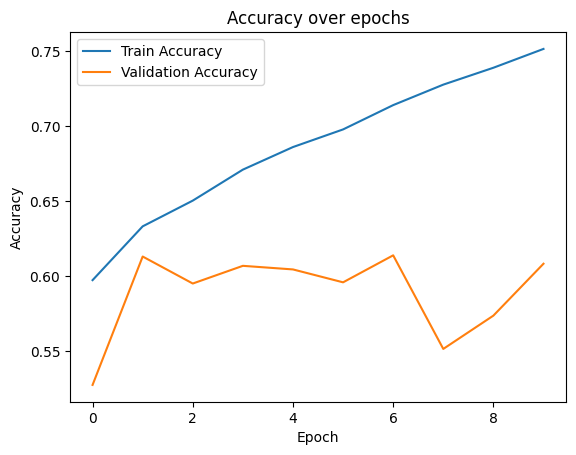

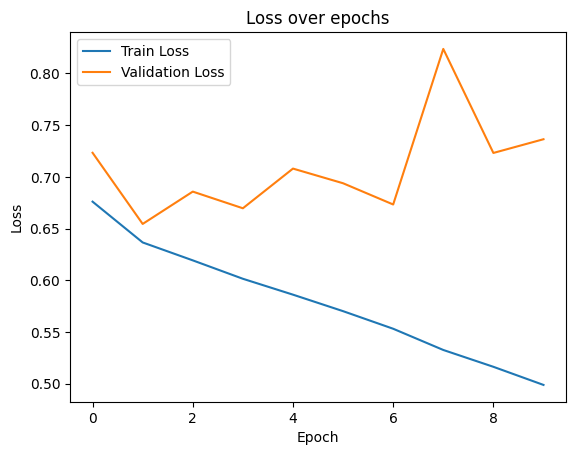

In [5]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Accuracy sur le test : {acc*100:.2f}%")

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


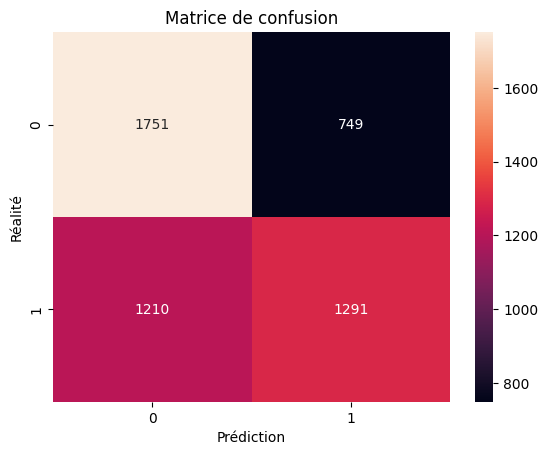

In [6]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

sns.heatmap(conf_matrix, fmt='d', annot=True)
plt.xlabel("Prédiction")
plt.ylabel("Réalité")
plt.title("Matrice de confusion")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


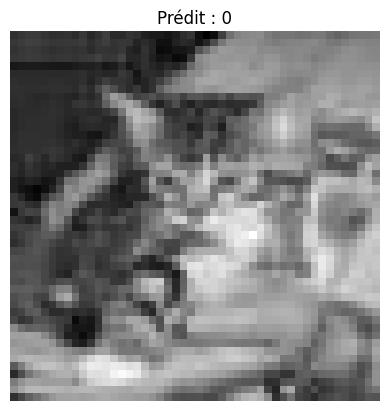

In [7]:
# Affichage d’un animal avec prédiction
img_to_predict = 397
plt.imshow(X_test[img_to_predict].reshape(img_size, img_size),cmap="grey")
plt.title(f"Prédit : {model.predict(X_test[[img_to_predict]]).argmax()}")
plt.axis('off')
plt.show()

In [ ]:
# MLFlow
mlflow.set_experiment("First Experiment")
mlflow.set_tracking_uri("http://localhost:5000/")

with mlflow.start_run():
    mlflow.log_params(parameters)
    mlflow.log_metrics({
        "accuracy": acc,
        "loss": loss
    })
    mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="Cats and Dogs model",
            input_example=X_test[:5],
            signature = infer_signature(X_test, model.predict(X_test))
        )

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
🏃 View run stylish-shoat-226 at: http://localhost:5000/#/experiments/1/runs/8dec431bd1be40f98225f2867fee8c2a
🧪 View experiment at: http://localhost:5000/#/experiments/1
